In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time
from IPython import display
import pathlib

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [247]:
#make gifs from generated images
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-5gv4ngac
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-5gv4ngac
  Resolved https://github.com/tensorflow/docs to commit af1c1d2ceac5d015c9f6ee5ed5b30eb2d2f5f6c1
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=182618 sha256=c59ea0c0104061c3f7d7e5460e25ac056d5187dd6ccf2822f3fefac671c6fdc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-xqmxvpm5/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [3]:
pwd

'/content'

In [5]:
ls

sample_data/


In [8]:
img_dir="/content/sample_data/smalldataset"

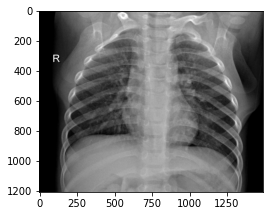

In [11]:
plt.figure(figsize=(4, 4))
plt.imshow(plt.imread("NORMAL2-IM-1330-0001.jpeg"),cmap="gray")

Text(0.5, 1.0, 'DCGANS results')

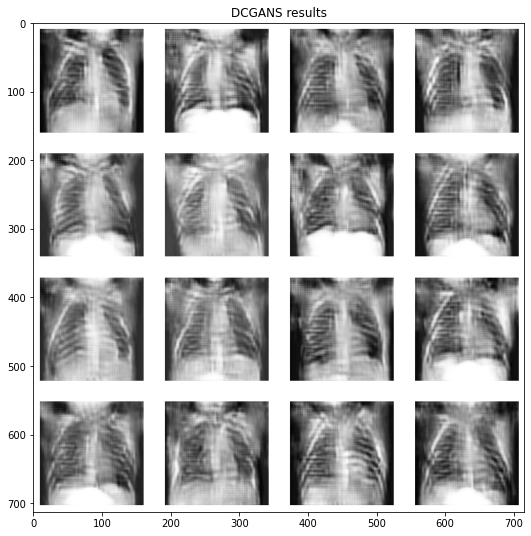

In [15]:
#RESULTS
plt.figure(figsize=(9, 9))
plt.imshow(plt.imread("xrays.png"))
plt.title("DCGANS results")

In [10]:
image_count = len(list(glob.glob('/content/sample_data/smalldataset/*.jpeg')))
image_count

533

In [168]:
batch_size = 32
img_height = 180
img_width = 180

In [169]:
dataset = keras.preprocessing.image_dataset_from_directory(
    img_dir, label_mode=None, image_size=(img_height, img_width),\
    batch_size=batch_size
)

Found 533 files belonging to 1 classes.


In [170]:
dataset = dataset.map(lambda x: x / 255.0)

In [220]:
#input is noise
#moving from Big to small
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(45*45*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((45, 45, 256)))
    assert model.output_shape == (None, 45, 45, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 45, 45, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 45, 45, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 90, 90, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 180, 180, 3)

    return model

#output is fake image

In [221]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)


In [222]:
generator.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 518400)            51840000  
                                                                 
 batch_normalization_18 (Bat  (None, 518400)           2073600   
 chNormalization)                                                
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 518400)            0         
                                                                 
 reshape_6 (Reshape)         (None, 45, 45, 256)       0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 45, 45, 128)      819200    
 Transpose)                                                      
                                                                 
 batch_normalization_19 (Bat  (None, 45, 45, 128)    

In [223]:
generated_image.numpy().shape

(1, 180, 180, 3)

In [224]:
generated_image.numpy().reshape(180, 180, 3).shape

(180, 180, 3)

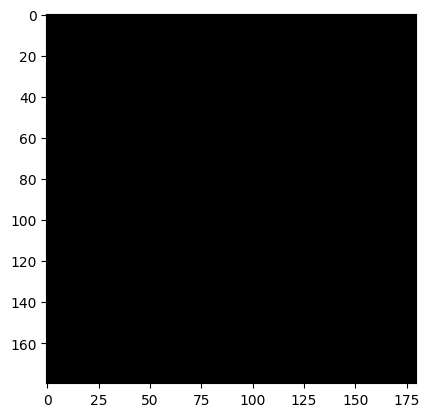

In [225]:
plt.imshow(generated_image.numpy().reshape(180, 180, 3))

In [226]:
#input is fake image
#moving from Small to big
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[180, 180, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [227]:
discriminator = make_discriminator_model()
discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00058759]], dtype=float32)>

In [228]:
discriminator.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 90, 90, 64)        4864      
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 90, 90, 64)        0         
                                                                 
 dropout_30 (Dropout)        (None, 90, 90, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 45, 45, 128)       204928    
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 45, 45, 128)       0         
                                                                 
 dropout_31 (Dropout)        (None, 45, 45, 128)       0         
                                                                 
 flatten_13 (Flatten)        (None, 259200)          

In [229]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [230]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [231]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [232]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [233]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [236]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

In [237]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [238]:
@tf.function
def train_step(images):
    #gets random noise in batch size
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #GENERATOR
        generated_images = generator(noise, training=True)
        
        #discrimainator train on real images
        real_output = discriminator(images, training= True)
        
        #discrimainator train on fake images
        fake_output = discriminator(generated_images, training= True)
        
        #Get LOSSES
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        #get gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        #optimizers
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss
    

In [239]:
def train(dataset, epochs):
  g_loss =[]
  d_loss=[]
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
    
    g_loss.append(gen_loss)
    d_loss.append(disc_loss)
       

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print("EPOCH LOSS",gen_loss, disc_loss)
    print("Epoch \n")

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,seed)
  
  return g_loss,d_loss

In [240]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(9, 9))

  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5,cmap="gray" )
      plt.axis('off')
  
  plt.show()

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  if (epoch + 1) % 50 == 0:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  

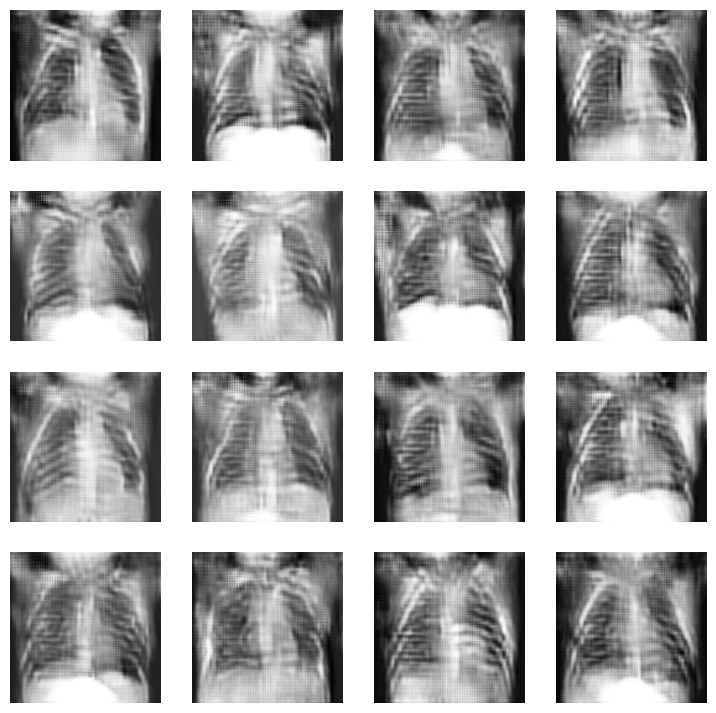

In [242]:
g_loss,d_loss= train(dataset, EPOCHS)

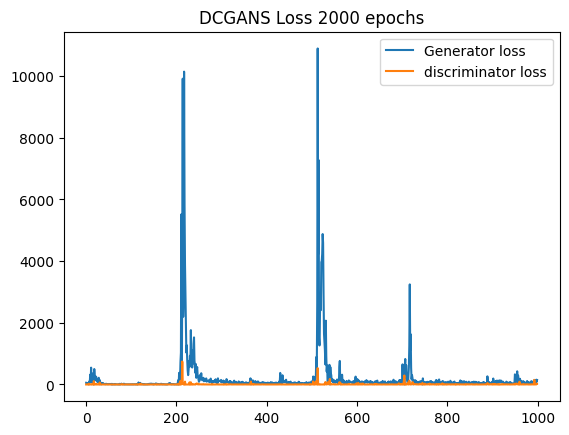

In [246]:
plt.plot(g_loss,label="Generator loss")
plt.plot(d_loss, label="discriminator loss")
plt.title("DCGANS Loss 2000 epochs")
plt.legend()
plt.show()

In [4]:
import matplotlib.pyplot as plt


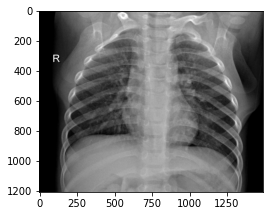

In [12]:
plt.figure(figsize=(4, 4))
plt.imshow(plt.imread("NORMAL2-IM-1330-0001.jpeg"),cmap="gray")

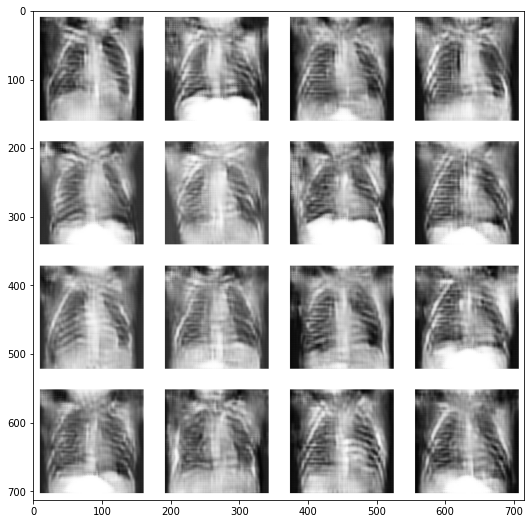

In [6]:
plt.figure(figsize=(9, 9))
plt.imshow(plt.imread("xrays.png"))

Text(0.5, 1.0, 'DCGANS early results 50 epochs ')

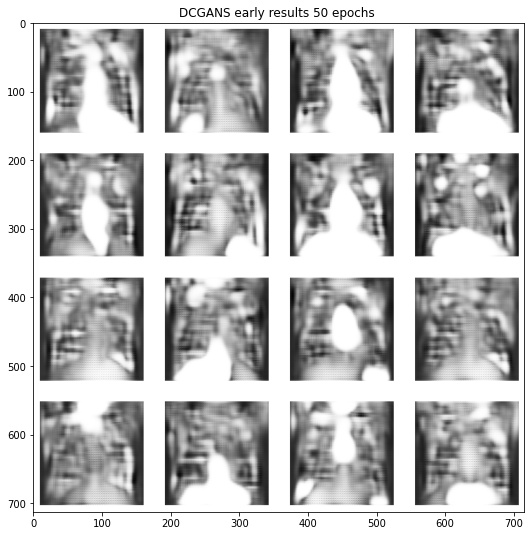

In [19]:
plt.figure(figsize=(9, 9))
plt.imshow(plt.imread("xray1.png"))
plt.title("DCGANS early results 50 epochs ")

In [248]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [254]:
anim_file = 'xrays.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-254-d042814bad17>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-254-d042814bad17>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



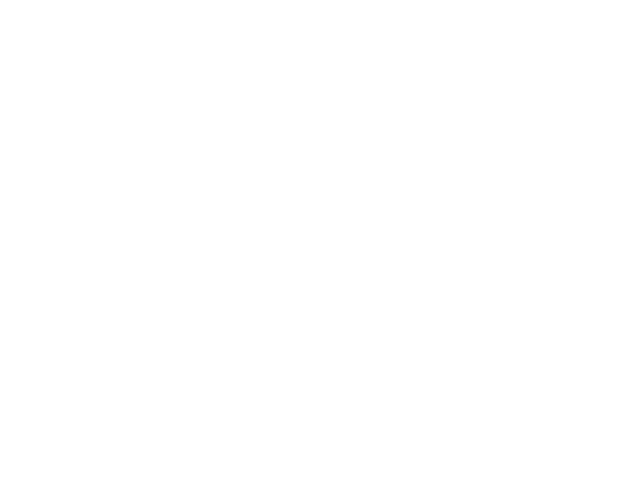

In [253]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)